In [1]:
import pandas as pd
import numpy as np
from eliana.datasets import ParlogsObservations
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import DBSCAN

In [ ]:
from src.preprocesamiento import extract_params, extract_trace_parameters, cargar_y_procesar_carpeta, extract_trace_categoricals,min_max_normalizar
from src.codificacion import codificar_categoricas_por_columna, procesar_strval_in_memory,decodificar_categoria

from src.visualizacion import graficos_por_columna,plot_clusters
from src.clustering import clustering_completo,construir_dataset_enriquecido,aplicar_clustering

#### 1. Carga inicial y metadatos

In [4]:
INSTRUMENT='MATISSE'
RANGE='6m'
logs = ParlogsObservations(period=RANGE, source="Instrument", system=INSTRUMENT)
df_meta = logs.meta
df_traces = logs.traces()

In [5]:
TPL_IDs = logs.meta['TPL_ID'].value_counts()
print("Conteo de TPL_IDs:\n", TPL_IDs)

Conteo de TPL_IDs:
 TPL_ID
MATISSE_hyb_obs                      1612
MATISSE_img_acq                      1467
MATISSE_gen_tec_opd                  1059
MATISSE_gen_cal_bias                  724
MATISSE_gen_cal_imbasic               399
MATISSE_gen_cal_transfunc             241
MATISSE_gen_tec_standby               199
MATISSE_gen_tec_ali                   185
MATISSE_gen_tec_check_fringes         183
MATISSE_img_acq_ft                    174
MATISSE_gen_tec_simple_rec            130
MATISSE_gen_cal_kappa                  56
MATISSE_gen_cal_shift                  50
CALOB_gen_tec_log                      37
errseverity                            33
MATISSE_gen_tec_setup_coude_train      27
MATISSE_gen_cal_det_aq                 22
MATISSE_gen_cal_det_h2                 21
MATISSE_gen_tec_piezos                 13
MATISSE_gen_tec_setup_lab               7
MATISSE_gen_cal_imext_aq                5
MATISSE_gen_cal_imrem_aq                3
MATISSE_gen_cal_imrem                   2
MATISSE

In [6]:
print("Shape df_meta:", df_meta.shape)
print("Shape df_traces:", df_traces.shape)
print("\nDistribución de ERROR:\n", df_meta["ERROR"].value_counts())

Shape df_meta: (6653, 11)
Shape df_traces: (7094587, 15)

Distribución de ERROR:
 ERROR
False    6383
True      270
Name: count, dtype: int64


#### 3. Extracción de parámetros categoricos y numericos

In [7]:
tpl_params_dict, tpl_strval_dict = {}, {}
TPL = df_meta["TPL_ID"].unique()
threshold_nan = 0.9

for tpl_id in TPL:
    # Numéricos
    df_num = extract_trace_parameters(df_meta, df_traces, extract_params, tpl_id=tpl_id)
    df_num = df_num.loc[:, df_num.isna().mean() < threshold_nan]
    if not df_num.empty:
        tpl_params_dict[tpl_id] = df_num

    # Categóricos
    df_cat = extract_trace_categoricals(df_meta, df_traces, extract_params, tpl_id=tpl_id)
    if not df_cat.empty:
        tpl_strval_dict[tpl_id] = df_cat

print("Ejemplo parámetros numéricos:", list(tpl_params_dict.keys())[:5])
print("Ejemplo parámetros categóricos:", list(tpl_strval_dict.keys())[:5])

Ejemplo parámetros numéricos: ['MATISSE_img_acq', 'MATISSE_hyb_obs', 'MATISSE_gen_cal_imbasic', 'MATISSE_gen_tec_opd', 'MATISSE_gen_cal_transfunc']
Ejemplo parámetros categóricos: ['MATISSE_img_acq', 'MATISSE_hyb_obs', 'MATISSE_gen_cal_imbasic', 'MATISSE_gen_tec_opd', 'MATISSE_gen_cal_transfunc']


#### 4. Codificación de categóricos

In [8]:
codified_strval_dfs, dict_codificacion = procesar_strval_in_memory(tpl_strval_dict)
print("Codificación categórica completada.")

Codificación categórica completada.


#### 5. Dataset enriquecido
Unificamos parámetros numéricos + categóricos codificados.

In [9]:
df_enriched = construir_dataset_enriquecido(
    df_meta,
    tpl_params_dict,
    codified_strval_dfs
)

print("Shape dataset enriquecido:", df_enriched.shape)
print("Columnas:", df_enriched.columns[:15])
print("\nDistribución de ERROR:\n", df_enriched["ERROR"].value_counts())

Shape dataset enriquecido: (6653, 1936)
Columnas: Index(['START', 'END', 'TIMEOUT', 'system', 'procname', 'TPL_ID', 'ERROR',
       'USER_ABORT', 'SECONDS', 'TEL', 'TPL_EXEC',
       'NUM_MATISSE_img_acq.COU.AG.ALPHA', 'NUM_MATISSE_img_acq.COU.AG.DELTA',
       'NUM_MATISSE_img_acq.COU.AG.EPOCH',
       'NUM_MATISSE_img_acq.COU.AG.EQUINOX'],
      dtype='object')

Distribución de ERROR:
 ERROR
False    6383
True      270
Name: count, dtype: int64


#### 6. Clustering (tSNE, Kmeans, DBSCAN)

#### 7. Visualización de clusters

C:\Users\vosse\AppData\Local\Temp\ipykernel_27068\674317771.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(set(labels)))


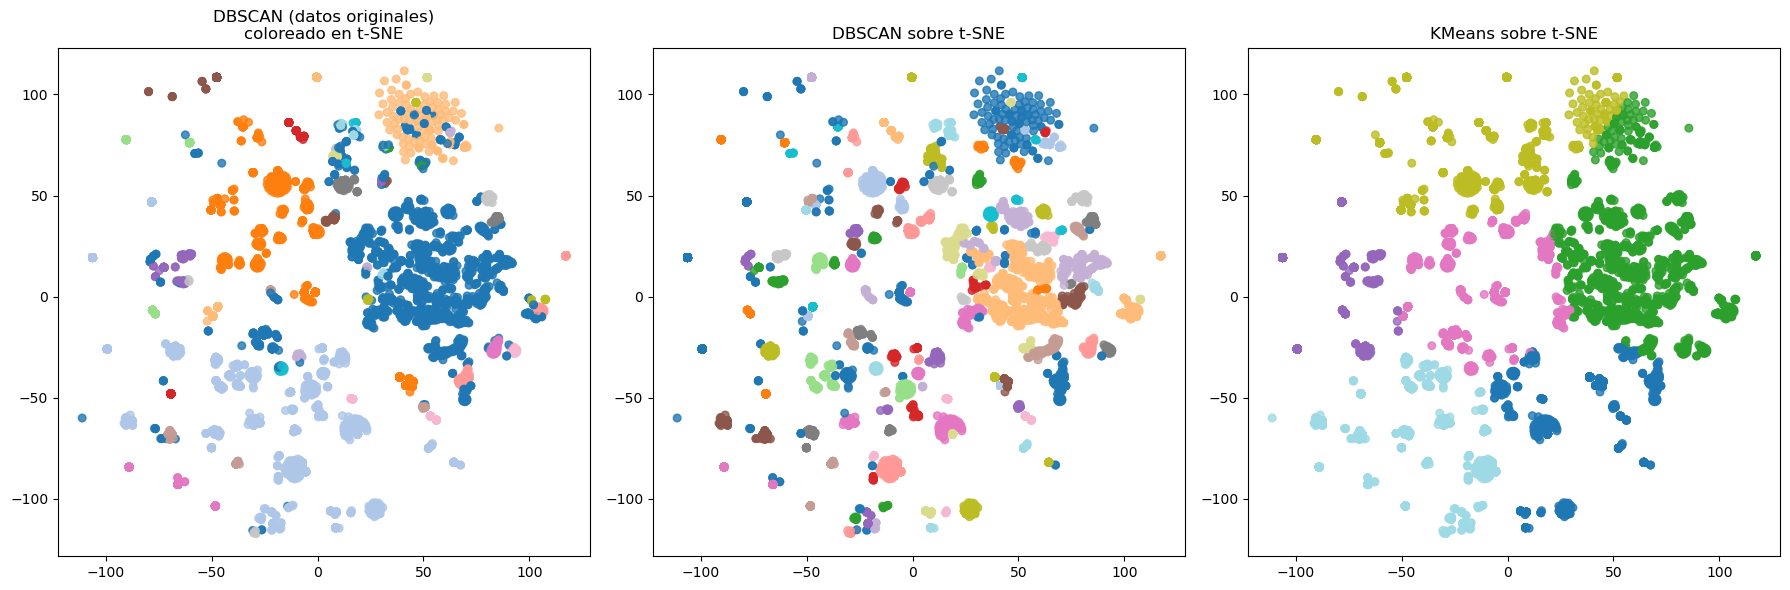

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.cm as cm

num_cols = [c for c in df_enriched.columns if c.startswith("NUM_")]
X = df_enriched[num_cols].fillna(0).values
X_scaled = StandardScaler().fit_transform(X)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# DBSCAN sobre datos originales
labels_dbscan = DBSCAN(eps=2, min_samples=5).fit_predict(X_scaled)

# DBSCAN sobre t-SNE
labels_dbscan_tsne = DBSCAN(eps=3, min_samples=5).fit_predict(X_tsne)

# KMeans sobre t-SNE
kmeans = KMeans(n_clusters=6, random_state=42)
labels_kmeans_tsne = kmeans.fit_predict(X_tsne)

df_enriched["Cluster_DBSCAN"] = labels_dbscan
df_enriched["Cluster_DBSCAN_TSNE"] = labels_dbscan_tsne
df_enriched["Cluster_KMeans_TSNE"] = labels_kmeans_tsne

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

def plot(ax, X, labels, title):
    cmap = cm.get_cmap("tab20", len(set(labels)))
    sc = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap=cmap, s=30, alpha=0.8)
    ax.set_title(title)
    return sc

#DBSCAN sobre datos originales
plot(axs[0], X_tsne, labels_dbscan, "DBSCAN (datos originales)\ncoloreado en t-SNE")

#DBSCAN sobre t-SNE
plot(axs[1], X_tsne, labels_dbscan_tsne, "DBSCAN sobre t-SNE")

#KMeans sobre t-SNE
plot(axs[2], X_tsne, labels_kmeans_tsne, "KMeans sobre t-SNE")

plt.tight_layout()
plt.show()